### 統計學習與深度學習
### Homework 4

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

#### 資料載入
使用下面的程式碼載入資料:

In [ ]:
!pip install gdown
!gdown --id "1PLkuJ9lo8YB9vt_84tW9Z_xRPY_Ymued"  

Downloading...
From: https://drive.google.com/uc?id=1PLkuJ9lo8YB9vt_84tW9Z_xRPY_Ymued
To: /content/msd_full.pickle
100% 375M/375M [00:01<00:00, 210MB/s]


In [ ]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
rg = LinearRegression().fit(X_train, Y_train)
y_predict = rg.predict(X_test)
rmse = mean_squared_error(Y_test, y_predict, squared=False)
top_five = rg.coef_[:5]
print('RMSE:',  rmse)
print('前五個特徵的參數:', top_five)

RMSE: 9.510160684544399
前五個特徵的參數: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn  # 定義基本的 layer 元件
import torch.nn.functional as F  # 定義 activation function 等
import torch.utils.data as Data  
from torch.utils.data import Dataset, DataLoader  # 定義 Dataset 及 DataLoader 等資料相關 Class
from torch.autograd import Variable

In [ ]:
# 打包 tensor
for_train = Data.TensorDataset(torch.Tensor(X_subtrain), torch.Tensor(Y_subtrain))
for_valid = Data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(Y_valid))
for_test = Data.TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

# 進行數據封裝
train_data = Data.DataLoader(for_train, batch_size=1000, shuffle=False)
valid_data = Data.DataLoader(for_valid, batch_size=1000, shuffle=False)
test_data = Data.DataLoader(for_test, batch_size=1000, shuffle=False)

In [ ]:
use_gpu = torch.cuda.is_available()

if not use_gpu:
    print('CUDA is not available.  Train on CPU ...')
else:
    print('CUDA is available!  Train on GPU ...')

CUDA is available!  Train on GPU ...


In [ ]:
class MyOwnNet(nn.Module):
    def __init__(self, input_size, hidden_nodes_size, num_of_classes):
        super(MyOwnNet, self).__init__()  # 初始化 nn.Module class
        self.func0 = nn.Linear(input_size, hidden_nodes_size)
        self.relu0 = nn.ReLU()
        self.func1 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu1 = nn.ReLU()
        self.func2 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu2 = nn.ReLU()
        self.func3 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu3 = nn.ReLU()
        self.func4 = nn.Linear(hidden_nodes_size, num_of_classes)

    def forward(self, x):
        outputs = self.func0(x)
        outputs = self.relu0(outputs)  # input
        outputs = self.func1(outputs)
        outputs = self.relu1(outputs)  # layer1
        outputs = self.func2(outputs)
        outputs = self.relu2(outputs)  # layer2
        outputs = self.func3(outputs)
        outputs = self.relu3(outputs)  # layer3
        outputs = self.func4(outputs)
        return outputs

In [ ]:
def my_model(hidden_nodes_size, weight_decay, plot_rmse):
    Net = MyOwnNet(input_size=90, hidden_nodes_size=hidden_nodes_size, num_of_classes=1).cuda()

    calc_loss = nn.MSELoss(reduction='sum')  # loss
    optimizer = torch.optim.SGD(Net.parameters(), lr=0.00001, weight_decay=weight_decay)  # optimizer

    epoch_num = 100
    min_loss = 500000  # 先隨便設
    limit = 5000
    train_RMSEs = []
    valid_RMSEs = []
    count = 0
    best_count = 0
    done = False
    total_training_loss = 0
    total_points = 0

    '''Training'''
    for epoch in range(1, epoch_num+1):
        for step, (x_batch, y_batch) in enumerate(train_data):
            count += 1
            total_points += len(x_batch)

            # 定義一個 Variable
            x_batch1 = Variable(x_batch).cuda()   
            y_batch1 = Variable(y_batch).cuda()   

            Net.train()
            optimizer.zero_grad()  # 將模型的參數梯度初始化為0

            predict = Net(x_batch1)
            predict = predict.squeeze(-1)  # 壓縮維度

            training_loss = calc_loss(predict, y_batch1)
            training_loss.backward()  # 進行Backward Propagation
            optimizer.step()  # 針對Backward Propagation所得到的梯度調整參數

            total_training_loss += training_loss

            # 模型訓練時每100個Batch計算一次Training and Validation RMSE
            if count % 100 == 0:  
                train_rmse = math.sqrt(total_training_loss / (total_points))
                train_RMSEs.append(train_rmse)

                '''Validation'''
                Net.eval()  # 不隨機捨棄神經元
                total_validation_loss = 0
                
                for step, (x_batch, y_batch) in enumerate(valid_data):
                    x_batch1 = Variable(x_batch).cuda()   
                    y_batch1 = Variable(y_batch).cuda()   

                    predict = Net(x_batch1)
                    predict = predict.squeeze(-1)
                    validation_loss = calc_loss(predict, y_batch1)
                    total_validation_loss += validation_loss

                validation_rmse = math.sqrt(total_validation_loss / (len(X_valid)))
                valid_RMSEs.append(validation_rmse)

                if validation_rmse < min_loss:
                    best_count = count
                    min_loss = validation_rmse
                    chosen_model = Net

            if count > (best_count + limit) and validation_loss > min_loss:  # Early stopping
                done = True
                break      
        if done == True:
            break
    
    # 畫圖
    if plot_rmse == True:
        list_x = np.linspace(100, int(count - 1), int((count - 1) / 100))
        plt.plot(list_x, train_RMSEs, label = 'Training RMSE')
        plt.plot(list_x, valid_RMSEs, label = 'Validation RMSE')
        plt.legend()
        plt.xlabel('Step count')
        plt.ylabel('RMSE')

    '''列出列出 test rmse'''
    chosen_model.eval()
    total_testing_loss = 0

    for step, (x_batch, y_batch) in enumerate(test_data):
        x_batch1 = Variable(x_batch).cuda()
        y_batch1 = Variable(y_batch).cuda()     

        predict_output = Net(x_batch1)
        predict_output = predict_output.squeeze(-1)
        testing_loss = calc_loss(predict_output, y_batch1)
        total_testing_loss += testing_loss

    testing_rmse = math.sqrt(total_testing_loss / (len(X_test)))          
    # print('RMSE: ', testing_rmse)

    return testing_rmse

Test RMSE:  8.982402976510343


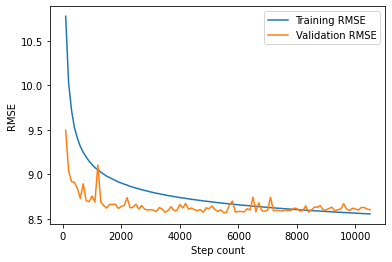

In [ ]:
rmse = my_model(hidden_nodes_size=45, weight_decay=0, plot_rmse = True)
print('Test RMSE: ', rmse)

#### 圖形意義：Training RMSE 和 Validation RMSE 一開始會先下降，而後趨於穩定；training RMSE為平滑曲線，validation RMSE 則會有所波動

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

In [ ]:
rmse = my_model(hidden_nodes_size=90, weight_decay=0, plot_rmse = False)
print('Test RMSE: ', rmse)

Test RMSE:  9.010800133338257


In [ ]:
rmse = my_model(hidden_nodes_size=180, weight_decay=0, plot_rmse = False)
print('Test RMSE: ', rmse)

Test RMSE:  9.123389114954547


#### Test RMSE 在 H=45 時最小，隨著 H 變大，Test RMSE 也逐漸上升 (H=180時最大)

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

In [ ]:
weight_list = [0.1, 0.2, 0.4]
h_list = [45, 90, 180]

for h in h_list:
    for w in weight_list:
        rmse = my_model(hidden_nodes_size=h, weight_decay=w, plot_rmse = False)
        print('H = ' + str(h) + '  |  ' + 'Weight decay = ' + str(w) + '  |  ' + 'Test RMSE: ' + str(rmse))

H = 45  |  Weight decay = 0.1  |  Test RMSE: 8.877401967131778
H = 45  |  Weight decay = 0.2  |  Test RMSE: 8.877487049055738
H = 45  |  Weight decay = 0.4  |  Test RMSE: 8.899219830211285
H = 90  |  Weight decay = 0.1  |  Test RMSE: 9.070444978441444
H = 90  |  Weight decay = 0.2  |  Test RMSE: 8.954781423997042
H = 90  |  Weight decay = 0.4  |  Test RMSE: 8.939614212621695
H = 180  |  Weight decay = 0.1  |  Test RMSE: 9.320342378016862
H = 180  |  Weight decay = 0.2  |  Test RMSE: 9.456306363559923
H = 180  |  Weight decay = 0.4  |  Test RMSE: 9.13042424598228


#### 無論選擇 weight decay 為多少，H = 45 的表現都最好 (RMSE 最小)，因此應選擇應選擇 H = 45

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [ ]:
class MyOwnNet1(nn.Module):
    def __init__(self, input_size, hidden_nodes_size, num_of_classes):
        super(MyOwnNet1, self).__init__()  # 初始化 nn.Module class
        self.func0 = nn.Linear(input_size, hidden_nodes_size)
        self.relu0 = nn.ReLU()
        self.drop0 = nn.Dropout(p=0.5)
        self.func1 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)
        self.func2 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.5)
        self.func3 = nn.Linear(hidden_nodes_size, hidden_nodes_size)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5)
        self.func4 = nn.Linear(hidden_nodes_size, num_of_classes)

    def forward(self, x):
        outputs = self.func0(x)
        outputs = self.relu0(outputs)  
        outputs = self.drop0(outputs)  # input
        outputs = self.func1(outputs)
        outputs = self.relu1(outputs)  
        outputs = self.drop1(outputs)  # layer1
        outputs = self.func2(outputs)
        outputs = self.relu2(outputs)  
        outputs = self.drop2(outputs)  # layer2
        outputs = self.func3(outputs)
        outputs = self.relu3(outputs)  
        outputs = self.drop3(outputs)  # layer3
        outputs = self.func4(outputs)
        return outputs

In [ ]:
def my_model1(hidden_nodes_size, weight_decay, plot_rmse):
    Net = MyOwnNet1(input_size=90, hidden_nodes_size=hidden_nodes_size, num_of_classes=1).cuda()

    calc_loss = nn.MSELoss(reduction='sum')  # loss
    optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=weight_decay)  # optimizer

    epoch_num = 100
    min_loss = 500000  # 先隨便設
    limit = 5000
    train_RMSEs = []
    valid_RMSEs = []
    count = 0
    best_count = 0
    done = False
    total_training_loss = 0
    total_points = 0

    '''Training'''
    for epoch in range(1, epoch_num+1):
        for step, (x_batch, y_batch) in enumerate(train_data):
            count += 1
            total_points += len(x_batch)

            # 定義一個 Variable
            x_batch1 = Variable(x_batch).cuda()   
            y_batch1 = Variable(y_batch).cuda()   

            Net.train()
            optimizer.zero_grad()  # 將模型的參數梯度初始化為0

            predict = Net(x_batch1)
            predict = predict.squeeze(-1)  # 壓縮維度

            training_loss = calc_loss(predict, y_batch1)
            training_loss.backward()  # 進行Backward Propagation
            optimizer.step()  # 針對Backward Propagation所得到的梯度調整參數

            total_training_loss += training_loss

            # 模型訓練時每100個Batch計算一次Training and Validation RMSE
            if count % 100 == 0:  
                train_rmse = math.sqrt(total_training_loss / (total_points))
                train_RMSEs.append(train_rmse)

                '''Validation'''
                Net.eval()  # 不隨機捨棄神經元
                total_validation_loss = 0
                
                for step, (x_batch, y_batch) in enumerate(valid_data):
                    x_batch1 = Variable(x_batch).cuda()   
                    y_batch1 = Variable(y_batch).cuda()   

                    predict = Net(x_batch1)
                    predict = predict.squeeze(-1)
                    validation_loss = calc_loss(predict, y_batch1)
                    total_validation_loss += validation_loss

                validation_rmse = math.sqrt(total_validation_loss / (len(X_valid)))
                valid_RMSEs.append(validation_rmse)

                if validation_rmse < min_loss:
                    best_count = count
                    min_loss = validation_rmse
                    chosen_model = Net

            if count > (best_count + limit) and validation_loss > min_loss:  # Early stopping
                done = True
                break      
        if done == True:
            break
    
    # 畫圖
    if plot_rmse == True:
        list_x = np.linspace(100, int(count - 1), int((count - 1) / 100))
        plt.plot(list_x, train_RMSEs, label = 'Training RMSE')
        plt.plot(list_x, valid_RMSEs, label = 'Validation RMSE')
        plt.legend()
        plt.xlabel('Step count')
        plt.ylabel('RMSE')

    '''列出列出 test rmse'''
    chosen_model.eval()
    total_testing_loss = 0

    for step, (x_batch, y_batch) in enumerate(test_data):
        x_batch1 = Variable(x_batch).cuda()
        y_batch1 = Variable(y_batch).cuda()     

        predict_output = Net(x_batch1)
        predict_output = predict_output.squeeze(-1)
        testing_loss = calc_loss(predict_output, y_batch1)
        total_testing_loss += testing_loss

    testing_rmse = math.sqrt(total_testing_loss / (len(X_test)))          
    # print('RMSE: ', testing_rmse)

    return testing_rmse

Test RMSE:  8.776953029382149


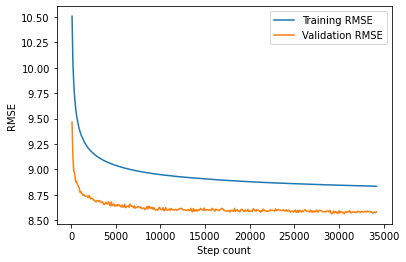

In [ ]:
rmse = my_model1(hidden_nodes_size=90, weight_decay=0, plot_rmse = True)
print('Test RMSE: ', rmse)

#### 圖形意義：Training RMSE 和 Validation RMSE 一開始會先下降，而後趨於穩定；training RMSE為平滑曲線，validation RMSE 則會小幅波動

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [ ]:
h_list = [20, 45, 180, 360]

for h in h_list:
    rmse = my_model1(hidden_nodes_size=h, weight_decay=0, plot_rmse = False)
    print('H = ' + str(h) +  '  |  ' + 'Test RMSE: ' + str(rmse))

H = 20  |  Test RMSE: 9.066075113109475
H = 45  |  Test RMSE: 8.865240184028169
H = 180  |  Test RMSE: 8.77411924109943
H = 360  |  Test RMSE: 8.747870921916023


#### H = 360 時 RMSE 最低，H = 20 時 RMSE 最高

#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [ ]:
def my_model2(hidden_nodes_size, weight_decay, plot_rmse, z):
    Net = MyOwnNet1(input_size=90, hidden_nodes_size=hidden_nodes_size, num_of_classes=1).cuda()

    SSELoss = nn.MSELoss(reduction='sum')  # L2 loss
    L1Loss = nn.L1Loss(reduction = 'sum')  # L1 loss
    optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=weight_decay)  # optimizer

    epoch_num = 100
    min_loss = 500000  # 先隨便設
    limit = 5000
    train_RMSEs = []
    valid_RMSEs = []
    count = 0
    best_count = 0
    done = False
    total_training_loss = 0
    total_points = 0

    '''Training'''
    for epoch in range(1, epoch_num+1):
        for step, (x_batch, y_batch) in enumerate(train_data):
            count += 1
            total_points += len(x_batch)

            # 定義一個 Variable
            x_batch1 = Variable(x_batch).cuda()   
            y_batch1 = Variable(y_batch).cuda()   

            Net.train()
            optimizer.zero_grad()  # 將模型的參數梯度初始化為0

            predict = Net(x_batch1)
            predict = predict.squeeze(-1)  # 壓縮維度

            sse_loss = SSELoss(predict, y_batch1)
            L1_loss = L1Loss(predict, y_batch1)
            training_loss = z * sse_loss + (1-z) * L1_loss

            training_loss.backward()  # 進行Backward Propagation
            optimizer.step()  # 針對Backward Propagation所得到的梯度調整參數

            total_training_loss += sse_loss

            # 模型訓練時每100個Batch計算一次Training and Validation RMSE
            if count % 100 == 0:  
                train_rmse = math.sqrt(total_training_loss / (total_points))
                train_RMSEs.append(train_rmse)

                '''Validation'''
                Net.eval()  # 不隨機捨棄神經元
                total_validation_loss = 0
                
                for step, (x_batch, y_batch) in enumerate(valid_data):
                    x_batch1 = Variable(x_batch).cuda()   
                    y_batch1 = Variable(y_batch).cuda()   

                    predict = Net(x_batch1)
                    predict = predict.squeeze(-1)
                    validation_loss = SSELoss(predict, y_batch1)
                    total_validation_loss += validation_loss

                validation_rmse = math.sqrt(total_validation_loss / (len(X_valid)))
                valid_RMSEs.append(validation_rmse)

                if validation_rmse < min_loss:
                    best_count = count
                    min_loss = validation_rmse
                    chosen_model = Net

            if count > (best_count + limit) and validation_loss > min_loss:  # Early stopping
                done = True
                break      
        if done == True:
            break
    
    # 畫圖
    if plot_rmse == True:
        list_x = np.linspace(100, int(count - 1), int((count - 1) / 100))
        plt.plot(list_x, train_RMSEs, label = 'Training RMSE')
        plt.plot(list_x, valid_RMSEs, label = 'Validation RMSE')
        plt.legend()
        plt.xlabel('Step count')
        plt.ylabel('RMSE')

    '''列出列出 test rmse'''
    chosen_model.eval()
    total_testing_loss = 0

    for step, (x_batch, y_batch) in enumerate(test_data):
        x_batch1 = Variable(x_batch).cuda()
        y_batch1 = Variable(y_batch).cuda()     

        predict_output = Net(x_batch1)
        predict_output = predict_output.squeeze(-1)
        testing_loss = SSELoss(predict_output, y_batch1)
        total_testing_loss += testing_loss

    testing_rmse = math.sqrt(total_testing_loss / (len(X_test)))          
    # print('RMSE: ', testing_rmse)

    return testing_rmse

Z = 0.5

Test RMSE:  8.77036291991787


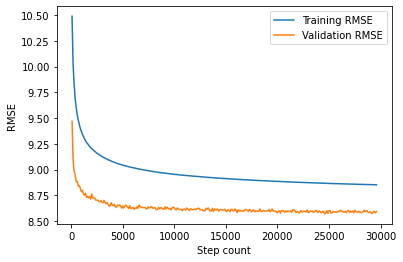

In [ ]:
rmse = my_model2(hidden_nodes_size=90, weight_decay=0, plot_rmse = True, z = 0.5)
print('Test RMSE: ', rmse)

使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)

In [ ]:
z_list = [0, 0.1, 0.5, 0.9, 1]

for z in z_list:
    rmse = my_model2(hidden_nodes_size=90, weight_decay=0, plot_rmse = False, z=z)
    print('Z = ' + str(z) +  '  |  ' + 'Test RMSE: ' + str(rmse))

Z = 0  |  Test RMSE: 9.01502118658791
Z = 0.1  |  Test RMSE: 8.782920597037593
Z = 0.5  |  Test RMSE: 8.767869848886429
Z = 0.9  |  Test RMSE: 8.784726795166863
Z = 1  |  Test RMSE: 8.78914887110339


#### 只使用 L1 loss 或只使用 L2 loss 來更新參數並不是最佳選擇；經調整後 (結合兩種 loss)，在 z=0.5 (兩種 loss 各佔一半) 時能得到最小的RMSE

#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [28]:
def customize_loss(y, yhat):
    total = 0
    for i in range(len(y)):
        if y[i] - yhat[i] > 0:
            total += 0.5 * (y[i] - yhat[i])
        elif yhat[i] - y[i] > 0:
            total += 0.5*(yhat[i] - y[i])

    return total

In [29]:
def my_model3(hidden_nodes_size, weight_decay, plot_rmse, z):
    Net = MyOwnNet1(input_size=90, hidden_nodes_size=hidden_nodes_size, num_of_classes=1).cuda()

    SSELoss = nn.MSELoss(reduction='sum')  # L2 loss
    optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=weight_decay)  # optimizer

    epoch_num = 100
    min_loss = 500000  # 先隨便設
    limit = 5000
    train_RMSEs = []
    valid_RMSEs = []
    count = 0
    best_count = 0
    done = False
    total_training_loss = 0
    total_points = 0

    '''Training'''
    for epoch in range(1, epoch_num+1):
        for step, (x_batch, y_batch) in enumerate(train_data):
            count += 1
            total_points += len(x_batch)

            # 定義一個 Variable
            x_batch1 = Variable(x_batch).cuda()   
            y_batch1 = Variable(y_batch).cuda()   

            Net.train()
            optimizer.zero_grad()  # 將模型的參數梯度初始化為0

            predict = Net(x_batch1)
            predict = predict.squeeze(-1)  # 壓縮維度

            customized_loss = customize_loss(y_batch1, predict)
            sse_loss = SSELoss(predict, y_batch1)
            
            training_loss = z * sse_loss + (1-z) * customized_loss

            training_loss.backward()  # 進行Backward Propagation
            optimizer.step()  # 針對Backward Propagation所得到的梯度調整參數

            total_training_loss += sse_loss

            # 模型訓練時每100個Batch計算一次Training and Validation RMSE
            if count % 100 == 0:  
                train_rmse = math.sqrt(total_training_loss / (total_points))
                train_RMSEs.append(train_rmse)

                '''Validation'''
                Net.eval()  # 不隨機捨棄神經元
                total_validation_loss = 0
                
                for step, (x_batch, y_batch) in enumerate(valid_data):
                    x_batch1 = Variable(x_batch).cuda()   
                    y_batch1 = Variable(y_batch).cuda()   

                    predict = Net(x_batch1)
                    predict = predict.squeeze(-1)
                    validation_loss = SSELoss(predict, y_batch1)
                    total_validation_loss += validation_loss

                validation_rmse = math.sqrt(total_validation_loss / (len(X_valid)))
                valid_RMSEs.append(validation_rmse)

                if validation_rmse < min_loss:
                    best_count = count
                    min_loss = validation_rmse
                    chosen_model = Net

            if count > (best_count + limit) and validation_loss > min_loss:  # Early stopping
                done = True
                break      
        if done == True:
            break
    
    # 畫圖
    if plot_rmse == True:
        list_x = np.linspace(100, int(count - 1), int((count - 1) / 100))
        plt.plot(list_x, train_RMSEs, label = 'Training RMSE')
        plt.plot(list_x, valid_RMSEs, label = 'Validation RMSE')
        plt.legend()
        plt.xlabel('Step count')
        plt.ylabel('RMSE')

    '''列出列出 test rmse'''
    chosen_model.eval()
    total_testing_loss = 0

    for step, (x_batch, y_batch) in enumerate(test_data):
        x_batch1 = Variable(x_batch).cuda()
        y_batch1 = Variable(y_batch).cuda()     

        predict_output = Net(x_batch1)
        predict_output = predict_output.squeeze(-1)
        testing_loss = SSELoss(predict_output, y_batch1)
        total_testing_loss += testing_loss

    testing_rmse = math.sqrt(total_testing_loss / (len(X_test)))          
    # print('RMSE: ', testing_rmse)

    return testing_rmse

Test RMSE:  8.98776515521804


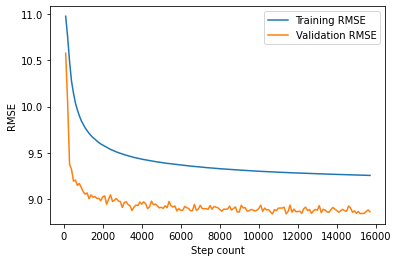

In [30]:
rmse = my_model3(hidden_nodes_size=90, weight_decay=0, plot_rmse = True, z=0)
print('Test RMSE: ', rmse)

In [ ]:
z_list = [0, 0.1, 0.5, 0.9, 1]

for z in z_list:
    rmse = my_model3(hidden_nodes_size=90, weight_decay=0, plot_rmse = False, z=z)
    print('Z = ' + str(z) +  '  |  ' + 'Test RMSE: ' + str(rmse))

Z = 0  |  Test RMSE: 8.981598585952263
